# Ready, Steady, Go AI (*Tutorial*)

This tutorial is a supplement to the paper, **Ready, Steady, Go AI: A Practical Tutorial on Fundamentals of Artificial Intelligence and Its Applications in Phenomics Image Analysis** (submitted to *Patterns, 2021*) by Farid Nakhle and Antoine Harfouche

Read the accompanying paper [here](https://doi.org).

# Table of contents


* **1. Background**
* **2. Downloading Segmented Images**
* **3. Balancing the Healthy Class with DCGAN**

# 1. Background


**Why do we need to balance a dataset?**

Data imbalance refers to an unequal distribution of classes within a dataset. In such scenario, a classification model could become biased, inaccurate and might produce unsatisfactory results. Therefore, we balance the dataset either by oversampling the minority class or undersampling the majority classes. To demonstrate the two scenarios, both oversampling and undersampling will be applied. Here, we will oversample the healthy class in the training set using the deep convolutional generative adversarial network (DCGAN) algorithm.

**What is DCGAN?**

Generative adversial network (GAN) algorithm was designed to generate new data instances that resemble training data. The idea was to pair two learning models, typically two ANNs, named generator and discriminator where the former learns to produce synthetic data, while the latter learns to distinguish true data from the output of the generator. During training, the generator tries to deceive the discriminator by synthesizing better data, while the discriminator becomes a better classifier. The equilibrium of this zero-sum game is reached when the discriminator can no longer distinguish real images from fakes.


DCGAN is very similar to GAN, except that it uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively, making it more suitable for synthesizing imaging data.


Here, we provided the DCGAN algorithm with the healthy class of the training set (1272 images) to train it on generating synthetic leaves, and thus, oversampling the set to 1500 images


# 2. Downloading Segmented Images


As a reminder, we are working with the PlantVillage dataset, originally obtained from [here](http://dx.doi.org/10.17632/tywbtsjrjv.1).
For this tutorial, we will be working with a subset of PlantVillage, where we will choose the tomato classes only. We have made the subset available [here](http://dx.doi.org/10.17632/4g7k9wptyd.1). 

The next code will automatically download the dataset segmented with SegNet.

**It is important to note that Colab deletes all unsaved data once the instance is recycled. Therefore, remember to download your results once you run the code.**

In [ ]:
import requests
import os
import zipfile

## FEEL FREE TO CHANGE THESE PARAMETERS
dataset_url = "http://faridnakhle.com/pv/tomato-split-cropped-segmented.zip"
save_data_to = "/content/dataset/tomato-segmented/"
dataset_file_name = "tomato-segmented.zip"
#######################################

if not os.path.exists(save_data_to):
    os.makedirs(save_data_to)

r = requests.get(dataset_url, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})

print("Downloading dataset...")  

with open(save_data_to + dataset_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

## Extract downloaded zip dataset file
print("Dataset downloaded")  
print("Extracting files...")  
with zipfile.ZipFile(save_data_to + dataset_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)

## Delete the zip file as we no longer need it
os.remove(save_data_to + dataset_file_name)
print("All done!")  


Dataset downloaded
Extracting files...
All done!


# 3. Balancing the Healthy Class with DCGAN

We will import PyTorch as we will use it for the implementation of DCGAN

In [ ]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
    ## YOU CAN CHANGE THESE VARIABLES    
    n_epochs = 500
    batch_size = 50
    lr = 0.0002
    b1 = 0.7 #adam: decay of first order momentum of gradient
    b2 = 0.999 #adam: decay of first order momentum of gradient
    n_cpu = 1
    latent_dim = 100 #dimensionality of the latent space
    img_size = 224
    channels = 3 #R, G, and B
    sample_interval = 400 #interval between image sampling
    ######################################################

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


def trainDCGAN():

    def weights_init_normal(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find("BatchNorm2d") != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

    os.makedirs("images", exist_ok=True)

    cuda = True if torch.cuda.is_available() else False

    load_from_checkpoint = False

    # Loss function
    adversarial_loss = torch.nn.BCELoss()

    # Initialize generator and discriminator
    generator = Generator()
    discriminator = Discriminator()

    if cuda:
        generator.cuda()
        discriminator.cuda()
        adversarial_loss.cuda()

    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

    # train set
    data_path = '/content/dataset/tomato-segmented/'
    train_dir = data_path + 'train/'

    train_dataset = datasets.ImageFolder(
        train_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]))
    
    dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=n_cpu, pin_memory=True)
        

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # ----------
    #  Load from Checkpoint
    # ----------

    if (load_from_checkpoint):
        checkpointName = "./images/checkpoint_epoch_1000.pth"
        checkpoint = torch.load(checkpointName)
        generator.load_state_dict(checkpoint['G_state_dict'])
        discriminator.load_state_dict(checkpoint['D_state_dict'])
        optimizer_G.load_state_dict(checkpoint['G_optimizer'])
        optimizer_D.load_state_dict(checkpoint['D_optimizer'])
        print("Loaded CheckPoint: " + checkpointName)
        if cuda:
            generator.cuda()
            discriminator.cuda()

    # ----------
    #  Training
    # ----------

    for epoch in range(n_epochs):
        for i, (imgs, _) in enumerate(dataloader):

            # Adversarial ground truths
            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

            # Generate a batch of images
            gen_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % ((epoch + 1), n_epochs, (i + 1), len(dataloader), d_loss.item(), g_loss.item())
            )

            batches_done = epoch * len(dataloader) + i
            if batches_done % sample_interval == 0:
                save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
        
        if epoch % 500 == 0:
            torch.save({
                    'G_state_dict': generator.state_dict(),
                    'D_state_dict': discriminator.state_dict(),
                    'G_optimizer': optimizer_G.state_dict(),
                    'D_optimizer': optimizer_D.state_dict(),
                    }, "images/checkpoint_epoch_" + str(epoch) +".pth")
   
    torch.save({
            'G_state_dict': generator.state_dict(),
            'D_state_dict': discriminator.state_dict(),
            'G_optimizer': optimizer_G.state_dict(),
            'D_optimizer': optimizer_D.state_dict(),
            }, "images/checkpoint_final.pth")
    
    print("Training complete")

**NB: To make running this notebook faster and our results easily reproducable, we made our trained model available and we will load it after this section. Thus, you might skip this next code block**

In [ ]:
trainDCGAN()

**In the next section, we will load our trained model to make our results reproducable. You can change the loading path to use your own instead**

In [ ]:
##########################
### DOWNLOAD THE MODEL ###
##########################

## FEEL FREE TO CHANGE THESE PARAMETERS
model_URL = "http://faridnakhle.com/pv/models/RSGAI_DCGAN.zip"
save_data_to = "/content/models/"
model_file_name = "dcgan.zip"
#######################################

if not os.path.exists(save_data_to):
    os.makedirs(save_data_to)

print("Downloading model...")  

r = requests.get(model_URL, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})
with open(save_data_to + model_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

## Extract downloaded zip dataset file
print("Model downloaded")  
print("Extracting files...")

with zipfile.ZipFile(save_data_to + model_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)
print("All done!")  


Model downloaded
Extracting files...
All done!


Now that we have a trained DCGAN model, we can use it to generate healthy tomato leaf images

In [ ]:
def GenerateImages(modelPath, outPutFolder, IMGS2GENERATE):
   
    if not os.path.exists(outPutFolder):
        os.makedirs(outPutFolder)

    ## YOU CAN CHANGE THESE VARIABLES    
    n_epochs = 1
    batch_size = 50
    lr = 0.0002
    b1 = 0.7 #adam: decay of first order momentum of gradient
    b2 = 0.999 #adam: decay of first order momentum of gradient
    n_cpu = 1
    latent_dim = 100 #dimensionality of the latent space
    img_size = 224
    channels = 3 #R, G, and B
    sample_interval = 400 #interval between image sampling
    ######################################################

    def weights_init_normal(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find("BatchNorm2d") != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

    cuda = True if torch.cuda.is_available() else False

    load_from_checkpoint = True

    # Loss function
    adversarial_loss = torch.nn.BCELoss()

    # Initialize generator and discriminator
    generator = Generator()
    discriminator = Discriminator()

    if cuda:
        generator.cuda()
        discriminator.cuda()
        adversarial_loss.cuda()

    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # ----------
    #  Load from Checkpoint
    # ----------

    if (load_from_checkpoint):
        checkpointName = modelPath
        checkpoint = torch.load(checkpointName)
        generator.load_state_dict(checkpoint['G_state_dict'])
        discriminator.load_state_dict(checkpoint['D_state_dict'])
        optimizer_G.load_state_dict(checkpoint['G_optimizer'])
        optimizer_D.load_state_dict(checkpoint['D_optimizer'])
        print("Loaded CheckPoint: " + checkpointName)
        if cuda:
            generator.cuda()
            discriminator.cuda()

    # ----------
    #  Generating images
    # ----------

    for i in range (0, IMGS2GENERATE):

        z = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim))))
        # Generate a batch of images
        gen_imgs = generator(z)
        save_image(gen_imgs.data, outPutFolder + "/DCGAN_%d.png" % (i + 1), nrow=0, normalize=True)

In [ ]:
GenerateImages('/content/models/RSGAI_DCGAN.pth', '/content/output/', IMGS2GENERATE = 228)
print("Data Generated")

Loaded CheckPoint: /content/models/RSGAI_DCGAN.pth
Data Generated


Let's preview some of the generated data

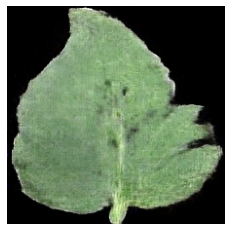

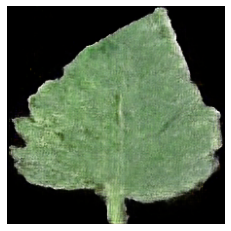

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgPath = '/content/output/DCGAN_'
imageOne = mpimg.imread(imgPath + "1.png")
imageTen = mpimg.imread(imgPath + "10.png")

plt.axis('off')
plt.imshow(imageOne)
plt.show()

plt.axis('off')
plt.imshow(imageTen)
plt.show()

The generated images can finally be added to the healthy class of our dataset